In [1]:
!pip install xgboost==1.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 148.9 MB 40 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [2]:
import os
if not os.path.exists('/content/train_data.ftr'):
  
  !pip install kaggle -q
  !mkdir ~/.kaggle 
  !cp kaggle.json ~/.kaggle/

  !rm /content/sample_data -r -q
  # !kaggle datasets download -d raddar/amex-data-integer-dtypes-parquet-format
  !kaggle datasets download -d munumbutt/amexfeather -q



rm: invalid option -- 'q'
Try 'rm --help' for more information.


In [3]:
from zipfile import ZipFile
import os

if not os.path.exists('/content/train_data.ftr'):

  with ZipFile('/content/amexfeather.zip', 'r') as zipObj:
      listOfFileNames = zipObj.namelist()

      # list_ext = ['train_data.ftr','test_data.ftr']
      list_ext = ['train_data.ftr']


      for f_name in listOfFileNames:
          if f_name in list_ext:
            zipObj.extract(f_name)



In [4]:
# import rapid
import cupy
import datetime
import re
import tensorflow as tf
# import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras.layers import LSTM
from keras.layers import Embedding
from tensorflow.keras.layers import Input,Activation,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate,Conv1D,MaxPool1D,Input,Flatten,Dropout,Normalization
from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import Embedding
# from tf.keras.preprocessing.text import Tokeni
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,\
LearningRateScheduler, TerminateOnNaN


import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from time import time
from zipfile import ZipFile
import tqdm
import pickle

import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_regression

import warnings
warnings.filterwarnings("ignore")
import shutil
import os

import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process
import multiprocessing
import codecs
import random as r
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import re
from nltk.util import ngrams
from sklearn.feature_selection import SelectKBest, chi2, f_regression

import scipy.sparse
import gc
import pickle as pkl
from datetime import datetime as dt
%matplotlib inline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,\
LearningRateScheduler, TerminateOnNaN

from sklearn.preprocessing import StandardScaler

import pickle
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn import set_config
set_config(display='diagram')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !rm /content/data/ -r
# !rm /content/processors -r
# !rm /content/model_para -r

In [6]:
if not os.path.exists('/content/data/train/x_train/'):
    
    os.makedirs('/content/data/train/x_train/')
    os.makedirs('/content/data/train/y_train/')

    os.makedirs('/content/data/val/x_val/')
    os.makedirs('/content/data/val/y_val/')

    os.makedirs('/content/processors/')
    os.makedirs('/content/model_para/')


if not os.path.exists('/content/drive/MyDrive/Applied_AI/casestudy/model_para'):
  os.makedirs('/content/drive/MyDrive/Applied_AI/casestudy/model_para')
  os.makedirs('/content/drive/MyDrive/Applied_AI/casestudy/model_para/model/xgb')
  os.makedirs('/content/drive/MyDrive/Applied_AI/casestudy/model_para/model/txt')
  os.makedirs('/content/drive/MyDrive/Applied_AI/casestudy/model_para/model/json')


drive_path = '/content/drive/MyDrive/Applied_AI/casestudy/model_para'

## Splitting Data into train

In [8]:
target = pd.read_csv('/content/train_labels.csv')
train,test = train_test_split(target,test_size=0.2,stratify=target['target'],random_state=33)

train_index, test_index= train['customer_ID'].values,test['customer_ID'].values

del train,test

##Feature Engiering Function

In [9]:
"""
input: df (dataframe)

  num_feature: all the numerical columns

  doing groupby operation based on customer_ID & the applying different
  aggregation operation like : mean, std, min, max, last.

  we will save each column with datatype = float16 
  to save space memory as data is very large


"""


def numerical_featute(df):
    all_cols = [c for c in list(df.columns) if c not in ['customer_ID','S_2']]
    cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
    num_features = [col for col in all_cols if col not in cat_features]


    new_df = df.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    new_df.columns = ['_'.join(x) for x in new_df.columns]

    for col in list(new_df.columns):
      new_df[col] = new_df[col].astype('float16')
    
    column_name = list(new_df.columns)

    return new_df

In [10]:
"""
input: df (dataframe)

  steps:
    
    1. getting all the categorical columns
    2. creating off set to handle np.nan , we will set np.nan as 1.
    3. column D_63, D_64 are string type categorical columns with '' as one class & -1 as another class
        we will replace '' with X & -1 with Y.
    4. getting the total number of statemns each unique customer had & storing it in a df_count.
    5. out of 11 categorical column 9 are numerical / label encoded hence we will use it label encoded
        with adding the offset value to handle the np.nan as 1.
    
    
    6. if train == True:
        we will use the sklearns OneHotEncoder to encode the categorical columns & the saving
        it as pkl file to transform the data without needing to fit it again.
    7. if train == False:
        we will transform the data directly.

"""

def categorical_featute_engg(df,train=False):

  # defining all the faetures

    one_hot_feature = ['D_63','D_64']
    cat = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_66","D_68"]
    offset = [2,1,2,2,3,2,3,2,2]  #2 minus minimal value in full train csv

    # Making categoriacl data drame with only categorical features
    df_cat = df[['customer_ID']+cat+one_hot_feature]

    df_cat[one_hot_feature] = df_cat[one_hot_feature].replace(r'', 'X', regex=True)
    df_cat[one_hot_feature] = df_cat[one_hot_feature].replace(r'-1', 'Y', regex=True)
    
    df_count = df.groupby('customer_ID')['S_2'].agg(['count'])
    df_count.columns = ['count']

    del df


    for col,s in zip(cat,offset):

      df_cat[col] = np.array(df_cat[col].values) + s
      df_cat[col] = df_cat[col].fillna(1).astype('int8')

    df_cat = df_cat.reset_index(drop=True)


    if train:

      if not os.path.exists('/content/model_para/one_hot_encoder_D_63_D_64.pkl'):

        pipe_one_hot_encoder = Pipeline(steps=[('one_hot_encoder',OneHotEncoder(handle_unknown='ignore'))])

        pipe_one_hot_encoder.fit(df_cat[one_hot_feature])

        pickle.dump(pipe_one_hot_encoder,open('/content/model_para/one_hot_encoder_D_63_D_64.pkl','wb'))
        pickle.dump(pipe_one_hot_encoder,open(drive_path + '/one_hot_encoder_D_63_D_64.pkl','wb'))

        # getting One Hot Encoded Feature Name
        one_hot_ = [[x[0]+'_'+y for y in list(x[1])] for x in zip(['D_63','D_64'],pipe_one_hot_encoder['one_hot_encoder'].categories_)]
        one_hot_ = one_hot_[0] + one_hot_[1]
        
        pickle.dump(one_hot_,open('/content/model_para/one_hot_encoder_D_63_D_64.pkl_feature_names','wb'))
        pickle.dump(one_hot_,open(drive_path + '/one_hot_encoder_D_63_D_64.pkl_feature_names','wb'))

        one_hot_df = pd.DataFrame(pipe_one_hot_encoder.transform(df_cat[one_hot_feature]).toarray().astype('int8'),columns=one_hot_)

      else:

        pipe_one_hot_encoder = pickle.load(open('/content/model_para/one_hot_encoder_D_63_D_64.pkl','rb'))
        one_hot_ =  pickle.load(open('/content/model_para/one_hot_encoder_D_63_D_64.pkl_feature_names','rb'))
        
        one_hot_df = pd.DataFrame(pipe_one_hot_encoder.transform(df_cat[one_hot_feature]).toarray().astype('int8'),columns=one_hot_)

      df_cat = df_cat.drop(['D_63','D_64'],axis=1)
      df_cat = pd.concat([df_cat,one_hot_df],axis=1)

      del one_hot_df



      df_cat = df_cat.groupby('customer_ID')[list(df_cat.columns)[1:]].agg(['first','last', 'nunique'])
      df_cat.columns = ['_'.join(x) for x in df_cat.columns]

      df_cat['customer_ID'] = df_cat.index
      df_cat = df_cat[['customer_ID']+list(df_cat.columns)[:-1]]
      df_cat = df_cat.reset_index(drop=True)

      for col in df_cat.columns[1:]:
        df_cat[col] = df_cat[col].astype('int8')


      df_cat = df_cat.merge(df_count,on='customer_ID')
      del df_count

      return df_cat


    else:
  
      pipe_one_hot_encoder = pickle.load(open('/content/model_para/one_hot_encoder_D_63_D_64.pkl','rb'))
      one_hot_ =  pickle.load(open('/content/model_para/one_hot_encoder_D_63_D_64.pkl_feature_names','rb'))
      
      one_hot_df = pd.DataFrame(pipe_one_hot_encoder.transform(df_cat[one_hot_feature]).toarray().astype('int8'),columns=one_hot_)
      

      df_cat = df_cat.drop(['D_63','D_64'],axis=1)
      df_cat = pd.concat([df_cat,one_hot_df],axis=1)

      del one_hot_df




      df_cat = df_cat.groupby('customer_ID')[list(df_cat.columns)[1:]].agg(['first','last', 'nunique'])
      df_cat.columns = ['_'.join(x) for x in df_cat.columns]

      df_cat['customer_ID'] = df_cat.index

      df_cat = df_cat[['customer_ID']+list(df_cat.columns)[:-1]]
      df_cat = df_cat.reset_index(drop=True)

      for col in df_cat.columns[1:]:
        df_cat[col] = df_cat[col].astype('int8')


      df_cat = df_cat.merge(df_count,on='customer_ID')
      del df_count

      return df_cat




##Fitting Data

In [11]:
if not (os.path.exists('/content/data/train/x_train/cat.ftr') and os.path.exists('/content/data/val/x_val/cat.ftr')):

  df = pd.read_feather('/content/train_data.ftr')

  train_df = df[df['customer_ID'].isin(train_index)]
  train_cat_df = categorical_featute_engg(train_df,train=True)

  del train_df

  test_df = df[df['customer_ID'].isin(test_index)]
  test_cat_df = categorical_featute_engg(test_df)

  del test_df

  if not os.path.exists('/content/data/train/x_train/cat.ftr'):
    train_cat_df.to_feather('/content/data/train/x_train/cat.ftr')
    test_cat_df.to_feather('/content/data/val/x_val/cat.ftr')
    
  del train_cat_df, test_cat_df, df

In [12]:
if not os.path.exists('/content/data/train/x_train/num_df.ftr'):

  df = pd.read_feather('/content/train_data.ftr')
  df = df.drop(['target'],axis=1)
  # Feature_engg For Numerical features

  if not os.path.exists('/content/data/train/x_train/num_df.ftr'):

    num_df = numerical_featute(df[df['customer_ID'].isin(train_index)])
    num_df = num_df.reset_index()
    num_df = num_df.replace(np.inf,np.nan)
    num_df = num_df.merge(target,on='customer_ID')

    tar = num_df[['customer_ID','target']]
    num_df = num_df.drop(['target'],axis=1)

    num_df.to_feather('/content/data/train/x_train/num_df.ftr')
    tar.to_feather('/content/data/train/y_train/target.ftr')
    # pickle.dump(tar,open('/content/data/train/y_train/target.pkl','wb'))

    del num_df

  if not os.path.exists('/content/data/val/x_val/num_df.ftr'):

    num_df = numerical_featute(df[df['customer_ID'].isin(test_index)])
    num_df = num_df.reset_index()
    num_df = num_df.replace(np.inf,np.nan)
    num_df = num_df.merge(target,on='customer_ID')


    tar = num_df[['customer_ID','target']]
    num_df = num_df.drop(['target'],axis=1)

    num_df.to_feather('/content/data/val/x_val/num_df.ftr')
    # pickle.dump(tar,open('/content/data/val/y_val/target.pkl','wb'))
    tar.to_feather('/content/data/val/y_val/target.ftr')


    del num_df, df


## Feature Standardization

In [13]:
if not os.path.exists('/content/processors/numerical_data_preprocessing_pipeline.pkl'):

  num_df = pd.read_feather('/content/data/train/x_train/num_df.ftr')

  pipe_num = Pipeline(steps=[
        ('imputer',SimpleImputer(missing_values=np.nan,strategy='median')),
        ('scalar', StandardScaler())
    ])

  pipe_num.fit(num_df.iloc[:,1:])

  pickle.dump(pipe_num,open('/content/processors/numerical_data_preprocessing_pipeline.pkl','wb'))
  pickle.dump(pipe_num,open(drive_path + '/numerical_data_preprocessing_pipeline.pkl','wb'))



In [14]:
if not os.path.exists('/content/processors/categorical_data_preprocessing_pipeline.pkl'):

  cat_df = pd.read_feather('/content/data/train/x_train/cat.ftr')

  # columns to standardize
  cat_colum_std = [x for x in list(cat_df.columns)[1:-1] if x.split('_')[-1]=='nunique']+['count']

  # columns not be standardize
  cat_colum_not_std = [x for x in list(cat_df.columns) if x not in [x for x in list(cat_df.columns)[1:-1] if x.split('_')[-1]=='nunique']+['count']]

    
  pipe_cat = Pipeline(steps=[
  ('scalar', StandardScaler())
  ])

  pipe_cat.fit(cat_df[cat_colum_std])
  pickle.dump(pipe_cat,open('/content/processors/categorical_data_preprocessing_pipeline.pkl','wb'))
  pickle.dump(pipe_cat,open(drive_path +'/categorical_data_preprocessing_pipeline.pkl','wb'))



## Transforming Data into Pipeline


In [15]:
cat_df = pd.read_feather(f'/content/data/train/x_train/cat.ftr')
# getting all the categoraical columns to standardize
cat_colum_std = [x for x in list(cat_df.columns)[1:-1] if x.split('_')[-1]=='nunique']+['count']

# getting all the categorical columns not to be standardized
cat_colum_not_std = [x for x in list(cat_df.columns) if x not in cat_colum_std ]


In [16]:
def data_std(path):

  feature_name = []
  # reading the data
  num_df = pd.read_feather(f'/content/data/{path}/x_{path}/num_df.ftr')
  cat_df = pd.read_feather(f'/content/data/{path}/x_{path}/cat.ftr')
  customer_ID = cat_df['customer_ID']

  # getting all the categoraical columns to standardize
  cat_colum_std = [x for x in list(cat_df.columns)[1:-1] if x.split('_')[-1]=='nunique']+['count']

  # getting all the categorical columns not to be standardized
  cat_colum_not_std = [x for x in list(cat_df.columns) if x not in cat_colum_std ]

  pickle.dump(cat_colum_std,open(drive_path+'/cat_col_std.pkl','wb'))
  pickle.dump(cat_colum_not_std,open(drive_path+'/cat_colum_not_std.pkl','wb'))

  # getting data standardization pipeline

  pipe_num = pickle.load(open('/content/processors/numerical_data_preprocessing_pipeline.pkl','rb'))
  pipe_cat = pickle.load(open('/content/processors/categorical_data_preprocessing_pipeline.pkl','rb'))

  feature_name += list(num_df.columns)[1:]
  train_num = pipe_num.transform(num_df.iloc[:,1:])
  
  # # saving target of each datapoint 
  # target = num_df['target'].values.reshape(-1,1)
  # pickle.dump(target,open(f'/content/data/{path}/y_{path}/{path}.pkl','wb'))


  del num_df

  feature_name += cat_colum_std
  train_cat_std = pipe_cat.transform(cat_df[cat_colum_std])

  feature_name += cat_colum_not_std[1:]
  train_cat_non_std = np.array(cat_df[cat_colum_not_std[1:]])

  del cat_df

  final_data = np.concatenate([train_num,train_cat_std,train_cat_non_std],axis=1)
  cupy.save(f'/content/data/{path}/x_{path}/{path}',final_data.astype('float16'))

  pickle.dump(feature_name,open('/content/processors/feature_name.pkl','wb'))
  pickle.dump(feature_name,open(drive_path + '/feature_name.pkl','wb'))

  del final_data


if not (os.path.exists('/content/data/train/x_train/train.npy') and \
        os.path.exists('/content/data/val/x_val/val.npy')):

  data_std('train')
  data_std('val')

##Fitting Model

In [17]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

def score(true,pred):

  pred = pd.DataFrame(pred,columns=['prediction'])
  true = pd.DataFrame(true,columns=['target'])
  amx_score = amex_metric(true,pred)
  return amx_score


In [18]:
import xgboost as xgb

def load_data(path):
  X = np.load(f'/content/data/{path}/x_{path}/{path}.npy')
  # Y = pickle.load(open(f'/content/data/{path}/y_{path}/target.pkl','rb'))
  Y = pd.read_feather(f'/content/data/{path}/y_{path}/target.ftr')


  return X,Y

X_train,Y_train = load_data('train')
# X_val,Y_val = load_data('val')



## Hyper Parameter tuning & Model fitting

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve

def k_fold_index(X,Y):

  cv_index = []
  train_index = []
  len_data = X.shape[0]
  # getting optimal k_value for the training data set
  k =  [x for x in range(4,20) if len_data%x == 0][0]
  cross_validator = StratifiedKFold(n_splits=k,random_state=33,shuffle=True)

  indexs = cross_validator.split(X=X, y=Y['target'].values)

  for i in indexs:
    train_index.append(i[0])
    cv_index.append(i[1])

  return train_index, cv_index, k

In [23]:
def Auc_score(X_train, y_train, max_tree_depth,number_of_estimators):

  AUC_SCORE = {}
  auc_pretty_table = []
  train_index ,cv_index, k_val = k_fold_index(X_train,y_train)

  l = ['n_estimetors','max_depth','train_AUC','val_AUC','AMX_train_score','AMX_val_score']
  ','.join(l)

  with open(drive_path+'/Auc_hyperpara_df.csv','w+') as f:
    f.write(','.join(l))
    f.write('\n')

    for i in tqdm(number_of_estimators):
      for j in tqdm(max_tree_depth):
        clf = XGBClassifier(tree_method='gpu_hist',
                            max_depth=j,
                            n_estimators=i,
                            n_jobs=-1,
                            single_precision_histogram=True)
        AUC_cv = 0
        AUC_train = 0
        for k in (range(k_val)):


          # Fitting the GBDT classifier algorithem & getting the probability score for Train
          #  & Cross Validation set     
      
          clf.fit(X_train[train_index[k]],Y_train['target'].iloc[train_index[k]].values.reshape(-1,1))
          y_cv_pred = clf.predict_proba(X_train[cv_index[k]] )
          y_train_pred = clf.predict_proba(X_train[train_index[k]])

          score_train = score(Y_train['target'].iloc[train_index[k]].values.reshape(-1,1),y_train_pred[:,1])
          score_val = score(Y_train['target'].iloc[cv_index[k]].values.reshape(-1,1),y_cv_pred[:,1])

          AUC_cv += roc_auc_score(Y_train['target'].iloc[cv_index[k]].values.reshape(-1,1),y_cv_pred[:,1])
          AUC_train += roc_auc_score(Y_train['target'].iloc[train_index[k]].values.reshape(-1,1),y_train_pred[:,1])

          _ = gc.collect()

          # #calculating the avarage AUC score for the HyperParameter
        AUC_SCORE[(i,j)] = [AUC_cv/k_val,AUC_train/k_val]     
        auc_pretty_table.append((i,j,AUC_cv/k_val,AUC_train/k_val,score_train,score_val))

        f.write(','.join(map(str,[i,j,AUC_cv/k_val,AUC_train/k_val,score_train,score_val])))
        f.write('\n')

  return AUC_SCORE,auc_pretty_table

In [24]:
# defining funcyion for creating table of result for diffrent
# Number of estimetor
# max depth,
# CV_AUC score 
# Train_AUC score
from prettytable import PrettyTable

def pretty_table_creator(column_name_array,value_column_data):
  y = PrettyTable()
  y.field_names = column_name_array
  for i in range(len(value_column_data)):
    row_value = []
    for j in value_column_data[i]:
      row_value.append(j)
    y.add_row(row_value)

  y.align = 'l'
  print(y)

In [25]:
if not os.path.exists(drive_path+'/Auc_hyperpara_df.pkl'):

  max_tree_depth = [x for x in range(1,6)]
  number_of_estimators =[100*x for x in range(1,11)]
  AUC_SCORE,auc_pretty_table = Auc_score(X_train, Y_train, max_tree_depth,number_of_estimators)

  auc_pretty_table = [(x[0],x[1],x[2],x[3],1-x[3],x[3]-x[2]) for x in auc_pretty_table]
  df_auc = pd.DataFrame(auc_pretty_table,columns=['No of estimators','Max leaf node in tree','CV AUC','Train AUC','Bias','variance'])
  pickle.dump(df_auc,open(drive_path+'/Auc_hyperpara_df.pkl','wb')) 

100%|██████████| 10/10 [2:44:48<00:00, 988.86s/it] 


In [73]:
# if not len(os.listdir(drive_path+'/model/xgb')) == 5:

#   if not os.path.exists(drive_path+'/model'):
#       os.makedirs(drive_path+'/model/txt')
#       os.makedirs(drive_path+'/model/json')
#       os.makedirs(drive_path+'/model/xgb')

#   auc_df = pd.read_csv(drive_path+'/Auc_hyperpara_df.csv')
#   auc_df = auc_df.sort_values(by=['AMX_train_score'],ascending=False)

#   train_index ,cv_index, k_val = k_fold_index(X_train,Y_train)
#   importances, oof , acc_main= [], [], []
#   feature_name = pickle.load(open('/content/processors/feature_name.pkl','rb'))

#   for i in range(k_val):
#     clf = XGBClassifier(tree_method='gpu_hist',
#                           max_depth=int(auc_df.iloc[0]['max_depth']),
#                           n_estimators=int(auc_df.iloc[0]['n_estimetors']),
#                           n_jobs=-1,
#                           single_precision_histogram=True,
#                           random_state=33
#                         )
#     clf.fit(X_train[train_index[i]],
#             Y_train['target'].iloc[train_index[i]].values.reshape(-1,1))

#     # saving Model

#     clf.save_model(drive_path+'model/txt'+f'/model_{i}.txt')
#     clf.save_model(drive_path+'model/json'+f'/model_{i}.json')
#     clf.save_model(drive_path+'model/xgb'+f'/model_{i}.xgb')

#     # getting the oof (out of fold prediction)
#     # calculating feature importance for fold k


#     dd_df = pd.DataFrame({'feature':feature_name, f'importance_{i}':list(clf.feature_importances_)})
#     importances.append(dd_df)


#     # infer the OOF (out of fold) of k fold
#     oof_preds = clf.predict_proba(X_train[cv_index[i]])
#     oof_df = Y_train.iloc[cv_index[i]]
#     oof_df['prediction'] = oof_preds[:,1]

#     oof.append(oof_df)

#     # getting the AMEX score
#     acc = score(Y_train['target'].iloc[cv_index[i]].values.reshape(-1,1),
#                 oof_preds[:,1])
#     acc_main.append(acc)
#     print('AMEX Kaggle Metric =', acc, "\n")

#     _ = gc.collect()
#     del dd_df, oof_preds, acc, oof_df

#   oof_final = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')

AMEX Kaggle Metric = 0.7642671576369617 

AMEX Kaggle Metric = 0.7694896595962263 

AMEX Kaggle Metric = 0.7603632477501608 

AMEX Kaggle Metric = 0.7659435616844168 

AMEX Kaggle Metric = 0.7594366234430266 



In [93]:
auc_df = pd.read_csv(drive_path+'/Auc_hyperpara_df.csv')
auc_df = auc_df.sort_values(by=['AMX_val_score'],ascending=False)
auc_df

,n_estimetors,max_depth,train_AUC,val_AUC,AMX_train_score,AMX_val_score
22,500,3,0.953999,0.960977,0.802643,0.772837
27,600,3,0.954107,0.961978,0.806734,0.772337
17,400,3,0.953740,0.959730,0.798901,0.772053
37,800,3,0.954137,0.963696,0.812203,0.771834
32,700,3,0.954124,0.962871,0.809630,0.771763
12,300,3,0.953433,0.958414,0.793320,0.771350
13,300,4,0.953550,0.962827,0.811906,0.771204
23,500,4,0.953602,0.967976,0.835488,0.770809
18,400,4,0.953567,0.965551,0.824290,0.770737
9,200,5,0.955735,0.968442,0.827788,0.770356


In [104]:
if not len(os.listdir(drive_path+'/model/xgb')) == 5:

  if not os.path.exists(drive_path+'/model'):
      os.makedirs(drive_path+'/model/txt')
      os.makedirs(drive_path+'/model/json')
      os.makedirs(drive_path+'/model/xgb')

  auc_df = pd.read_csv(drive_path+'/Auc_hyperpara_df.csv')
  auc_df = auc_df.sort_values(by=['AMX_val_score'],ascending=False)

  train_index ,cv_index, k_val = k_fold_index(X_train,Y_train)
  importances, oof , acc_main= [], [], []
  feature_name = pickle.load(open('/content/processors/feature_name.pkl','rb'))

  for i in range(k_val):
    clf = XGBClassifier(tree_method='gpu_hist',
                          max_depth=int(auc_df.iloc[0]['max_depth']),
                          n_estimators=int(auc_df.iloc[0]['n_estimetors']),
                          n_jobs=-1,
                          single_precision_histogram=True,
                          random_state=33
                        )
    clf.fit(X_train[train_index[i]],
            Y_train['target'].iloc[train_index[i]].values.reshape(-1,1))

    # saving Model

    clf.save_model(drive_path+'/model/txt'+f'/model_{i}.txt')
    clf.save_model(drive_path+'/model/json'+f'/model_{i}.json')
    clf.save_model(drive_path+'/model/xgb'+f'/model_{i}.xgb')

    # getting the oof (out of fold prediction)
    # calculating feature importance for fold k


    dd_df = pd.DataFrame({'feature':feature_name, f'importance_{i}':list(clf.feature_importances_)})
    importances.append(dd_df)


    # infer the OOF (out of fold) of k fold
    oof_preds = clf.predict_proba(X_train[cv_index[i]])
    oof_df = Y_train.iloc[cv_index[i]]
    oof_df['prediction'] = oof_preds[:,1]

    oof.append(oof_df)

    # getting the AMEX score
    acc = score(Y_train['target'].iloc[cv_index[i]].values.reshape(-1,1),
                oof_preds[:,1])
    acc_main.append(acc)
    print('AMEX Kaggle Metric =', acc, "\n")

    _ = gc.collect()
    del dd_df, oof_preds, acc, oof_df

  oof_final = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')

AMEX Kaggle Metric = 0.7740122201239236 

AMEX Kaggle Metric = 0.7690306640141068 

AMEX Kaggle Metric = 0.7724703375508509 

AMEX Kaggle Metric = 0.7725204050324884 

AMEX Kaggle Metric = 0.772837330456773 



In [106]:
X_val,Y_val = load_data('val')

In [107]:
for i in range(5):
  if i == 0:
    model = xgb.XGBClassifier()
    model.load_model(drive_path+'/model/xgb'+f'/model_{i}.xgb')

    preds = model.predict_proba(X_val)
  else:
    model.load_model(drive_path+'/model/xgb'+f'/model_{i}.xgb')
    preds += model.predict_proba(X_val)

In [144]:
# score with highest val AMEX score

print(f"AMEX score for the Out Of Bag set is : {score(oof_final['target'],oof_final['prediction'])}")
print(f'AMEX score for the validation set is : {score(Y_val,(preds/5)[:,1])}')

AMEX score for the Out Of Bag set is : 0.7721844842278176
AMEX score for the validation set is : 0.785203200313423


## Saving Model:

In [146]:
from sklearn.metrics import roc_auc_score,roc_curve, f1_score
fpr,tpr,ther = roc_curve(oof_final['target'],oof_final['prediction'])
best_ther = [(x[0],x[2]*(1-x[1])) for x in zip(ther,fpr,tpr)]

thersold = max(best_ther,key=lambda x:x[1])
pickle.dump(thersold[0],open(drive_path+'/default_thersold.pkl','wb'))

In [129]:
def confusion_matrix_plotter(y_test,y_test_pred,model,para,best_para):


  print(f'For {model} Classifier:')
  n = len(y_test)
  y_test_pred = [(1 if x >best_para else 0 ) for x in y_test_pred]
  C = confusion_matrix(y_test,y_test_pred)
  labels = [0,1]

  precision = (((C.T)/(C.sum(axis=1))).T)
  recall = (C/C.sum(axis=0))


  missclassified_point = ((n-np.trace(C))/n)*100
  print(f"\t\tTotal % Of Missclassified Points : {missclassified_point}%\n")
  print(f"\t\tF1 Score : {f1_score(y_test,y_test_pred)}%\n")

  print('\n',"-"*50, "Confusion matrix", "-"*50,'\n')

  plt.figure(figsize=[15,5])
  labels = [0,1]
  c_map = sns.light_palette("green")
  sns.heatmap(C,annot=True,cmap=c_map,fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('True Class')
  plt.title('\n"ConFusion Matrix"\n')
  plt.show()

  print('\n',"-"*50, "Precision matrix", "-"*50,'\n')

  plt.figure(figsize=[15,5])
  labels = [0,1]
  c_map = sns.light_palette("green")
  sns.heatmap(precision,annot=True,cmap=c_map,fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('True Class')
  plt.title("\nPrecision Matrix\n")
  plt.show()

  print('\n',"-"*50, "Recall matrix"    , "-"*50,'\n')

  plt.figure(figsize=[15,5])
  labels = [0,1]
  c_map = sns.light_palette("green")
  sns.heatmap(recall,annot=True,cmap=c_map,fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('True Class')
  plt.title('\nRecall Matrix\n')

For xgb Classifier:
		Total % Of Missclassified Points : 11.728751511717856%

		F1 Score : 0.8018407731247124%


 -------------------------------------------------- Confusion matrix -------------------------------------------------- 



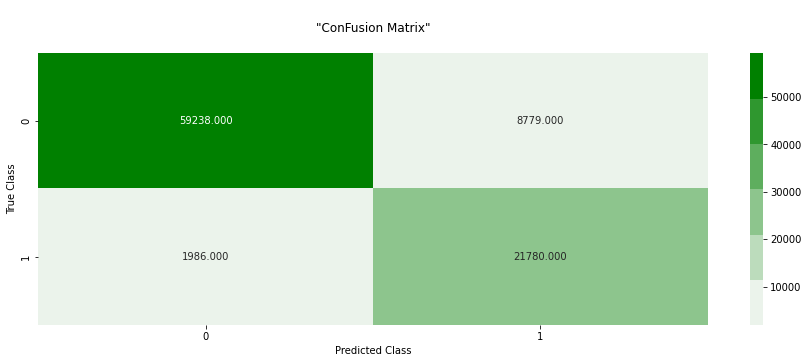


 -------------------------------------------------- Precision matrix -------------------------------------------------- 



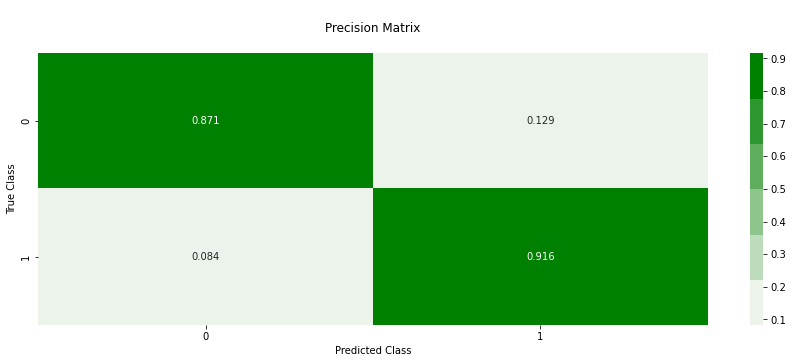


 -------------------------------------------------- Recall matrix -------------------------------------------------- 



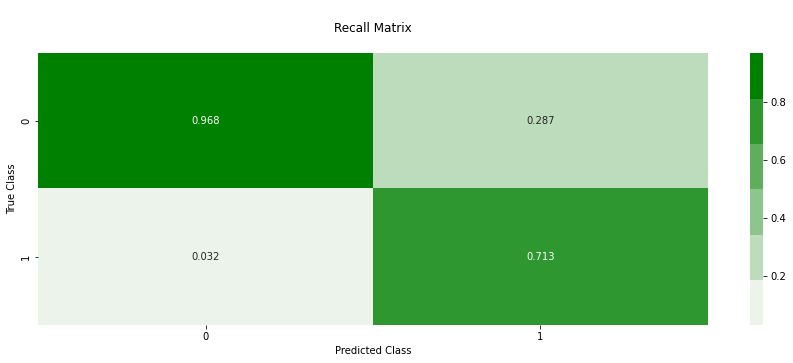

In [136]:
confusion_matrix_plotter(Y_val['target'],(preds/5)[:,1],model='xgb',para='thersol',best_para=thersold[0])


#Note
  * Please check the final.ipynb for the final test infetence

In [ ]:
# feature_name = pickle.load(open('/content/processors/feature_name.pkl','rb'))


In [ ]:
# feature_imp = { x[0]:x[1] for x in zip(feature_name,model.feature_importances_)}
# pickle.dump(feature_imp,open(drive_path + '/feature_importance.pkl','wb'))

# feature_imp_list = [ x for x in zip(feature_name,model.feature_importances_)]

In [147]:
# feature_imp_list.sort(key=lambda x:x[1],reverse=True)
